In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


Amazon Fine Food Review Analysis
The Amazon fine food reviews dataset consist of reviews of fine food from Amazon

1. Number of reviews: 568,454 reviews*
1. Number of Users : 256,059 users
1. Number of products : 74,258 products
1. Time span of taking reviews: Oct 1999 - Oct 2012
1. Number of attributes/column in Data: 10

Attributes: Information:

1. Id : Row Id
1. ProductId : Unique identifier for the product (74258 unique values )
1. UserId : Unqiue identifier for the user (256059 unique values)
1. ProfileName: Profile name of the user (218418 unique values)
1. HelpfulnessNumerator : Number of users who found the review helpful
1. HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not
1. Score : Rating between 1 and 5
1. Time : Timestamp for the review
1. Summary : Brief summary of the review (295744 unique values)
1. Text : Text of the review (393579 unique values ) (the most useful information for predicting postive or negative)
Objecive: Given a review ,determine whether a review is positive (Rating of 4 or 5) or negative(Rating of 1 or 2) ?

**Q). How to determine if a review is positive or negative ?**

*Ans). We could use the Score/rating. A rating of 4 or 5 could be considered as a positive review and A rating of 1 or 2 could be negative reviews. A rating of 3 neutral and can be ignored. This is the approximation and proxy way of determinig the polarity (positivity/negativity) of review.*

# Loading the data 
The dataset is available in two forms

1. .csv file
1. SqLite Database

***In order to load the database, We have used the SqLite Database as it easier to query tha data and visualise the data suffuciently. Here as we only want to get the global sentiment of the recommendation(Positve or Negative), we will purposefully ignore all the scores equal to 3 ,If the Score is above 3 ,then the recommendation or review will be set to "positive". Otherwise ,it will be set to "negative***

# Importing Important Library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import  metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from tqdm import tqdm
import os

import string
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import  WordNetLemmatizer
from nltk.corpus import stopwords

# Reading Data 

In [3]:
#Using Sqlite to read the data
con =sqlite3.connect('/kaggle/input/amazon-fine-food-reviews/database.sqlite')
#Filtering only Positive and Negative Reviews i.e
#not taking into consderation those reviews with Score=3
filtered_data=pd.read_sql_query(""" SELECT * FROM  Reviews WHERE Score!=3 """,con)

#Given a reviews with score>3 a Postive reating "1" & review with score <3 negative rating "0"
def partition(x):
    if x<3 :
        return 0
    return 1

# Changing reviews with Score <3 to be negative and score >3 to be positive 
actualScore = filtered_data['Score']
Postive_Negative = actualScore.map(partition)
filtered_data["Score"]=Postive_Negative
print("No. of data points in Dataset:",filtered_data.shape)
filtered_data.head(3)

No. of data points in Dataset: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Exploratory Data Analysis
## Data cleaning : Deduplication {The most important part of cleaning data }
It was observaed that (as shown in table below) that the reviews data had many deduplicates entries. Hence it was necessary to remove the deduplication in order to get unbaised results for the Analysis of the data. Following is the example given below 

In [4]:
display=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 AND UserId='AR5J8UI46CURR'
ORDER BY ProductId """,con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


***As it can be seen above the same user has multiple reviews of the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)***

**ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on**

**It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.**

**The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product**

In [5]:
# Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [6]:
#Deduplication of entries 
final_data =sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final_data.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
print('The total data remain after cleaning data ',(final_data['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

The total data remain after cleaning data  69.25890143662969


**Observation:** It was seen that 2 rows given below, the value of HelpfulnessNumerator is Greater than HelpfulnessDenominator which is not pratically hence such rows are too removed from dataset

In [8]:
display=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 AND Id=44737 OR Id=64422
ORDER BY ProductID""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final_data=final_data[final_data['HelpfulnessNumerator']<=final_data['HelpfulnessDenominator']]
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [10]:
# before starting the next phase of text preprocessing lets see the no. of entries left
print(final_data.shape)
#How many positive and negative reviews are present in our dataset?
final_data['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

# Text Preprocessing
**Now we have finished deduplication. Now our data requires some preprocessing before we go on futher anlysis and make the prediction model Hence in the preprocessing phase we do the following steps given below**

1. Begin by removing html tags
1. Removing any punctution or limited set of special character:like ,or . or # etc
1. Check the words is made up of english letters and is not alpha-numeric
1. Check to see if the length of the words is greater than 2 (as it was research that there is no adjective in 2 letter)
1. Convert the words to lowercase
1. Remove stopwords
1. Snowball stemming the word(it is observed that Snoball stemming is better that Porter stemming)

#### **After this we will collect the words and will use to describe positive and negative reviews.**

In [11]:
# printing some random reviews
sent_0 = final_data['Text'].values[6]
print(sent_0)
print("="*50)

sent_1000 = final_data['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final_data['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final_data['Text'].values[4900]
print(sent_4900)
print("="*50)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than s

In [12]:
import re    #Tutorial about Python regular expressions: https://pymotw.com/2/re/
# remove urls from text python : *https://stackoverflow.com/a/40823105/4084039*
sent_0=re.sub(r'https\S+','',sent_0)
sent_1000=re.sub(r'https\S+','',sent_1000)
sent_1500=re.sub(r'https\S+','',sent_1500)
sent_4900=re.sub(r'http\S+', '', sent_4900)
print(sent_0)


I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [13]:
#SENTENCES Containing HTML tags
import re
i=0;
for sentence in final_data['Text'].values:
    if (len(re.findall('<.*?>',sentence))):
        print(i)
        print(sentence)
        break;
    i=i+1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:
#stop=set(stopwords.words('english')) #set of stopwords
# we are removing the words from the stop words list: 'no', 'nor', 'not' for semantic meanig in bigrams and trigram
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn',  'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',  'weren', \
            'won', "won't", 'wouldn'])
stemming = nltk.stem.SnowballStemmer('english') #intialsing the snowball stemmer
def cleahtml(sentence): # funtion to remove html tags from words
    clean = re.compile('<.*?>')
    cleantext=re.sub(clean,' ',sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    clean=re.sub(r'[?|!|\'|"|#]',r'',sentence)
    clean_punc=re.sub(r'[.|,|)|(|\|/]',r' ',clean)
    return clean_punc

print('stop words are :',stopwords)
print("*********************")
print("*********************")
print('base word for tasty is :',stemming.stem('tasty'))

stop words are : {'same', 'as', 'how', 'or', 'once', 'won', 'other', 'this', 'some', 'been', 'is', 'will', 'mightn', 'a', 'our', 'does', 'd', 'through', 'yours', 'while', 'ours', 'himself', "it's", 'o', 'of', 'these', 'his', 'having', 'are', 'her', "shan't", 'they', 'in', 'don', 'its', 'had', 'own', "aren't", 'then', 'there', 'wouldn', "mightn't", 'before', 'shan', 'weren', 'those', 'couldn', 'to', 'isn', "you've", 'myself', 'again', 'was', 'she', 'that', 'when', 'should', 'were', 'hadn', "couldn't", 'me', 'at', 'on', 'ma', 'if', 'and', 'for', 'did', 'shouldn', 's', 'further', 'each', 'i', 'yourselves', 'here', 'than', 'he', "haven't", "hadn't", 'down', 'why', 'few', 'most', 'yourself', "needn't", "you're", "that'll", 'm', 'ourselves', 'so', 'him', 'needn', 'what', 'out', 'doesn', 'too', 'haven', 'off', "won't", 'their', 'over', 'up', 'theirs', 'during', "you'll", 'until', 'with', 'aren', 'where', 'hers', 'after', "hasn't", 're', 've', 'has', 'hasn', 'between', "don't", 'both', 'being'

In [15]:
# this code takes a while to run as it needs to run on 500k sentences.
#https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
if not os.path.isfile('finalsqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve review
    all_negative_words=[] # store words from -ve review
    for i , sentence in enumerate(tqdm(final_data['Text'].values)):
        filter_sentences =[]
        sent = cleahtml(sentence) #remove HTML tags
        for words in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(words).split():
                if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                    if(cleaned_words.lower() not in stopwords):
                        s=(stemming.stem(cleaned_words.lower())).encode('utf8')
                        filter_sentences.append(s)
                        if (final_data['Score'].values)[i]==1:
                            all_positive_words.append(s)  #list of all words used to describe positive reviews
                        if (final_data['Score'].values)[i]==0:
                            all_negative_words.append(s)  #list of all words used to describe negative reviews 
                    else:
                        continue
                else:
                    continue
        str1=b" ".join(filter_sentences) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)
        i+=1

100%|██████████| 364171/364171 [09:23<00:00, 646.28it/s]


In [16]:
##adding a column of CleanedText which displays the data after pre-processing of the review 
final_data['Cleaned_Text']=final_string
final_data['Cleaned_Text']=final_data['Cleaned_Text'].str.decode('utf-8')
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [17]:
#Store the final table into an SQLITE table for future
connection=sqlite3.connect('final12.sqlite')
c=connection.cursor
connection.text_factory=str
final_data.to_sql('Reviews',connection,schema=None,if_exists='replace',index=True,index_label=True,chunksize=None,dtype=None)
connection.close()

In [18]:
#connnn = sqlite3.connect("final12.sqlite")

#pd.read_sql_query(""" SELECT * FROM  Reviews WHERE Score!=3 """,connnn)


# Sorting dataset based on 'Time' feature

In [19]:
# converting time in unit=sec
final_data['Time']=pd.to_datetime(final_data['Time'],unit='s')
final_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,2007-11-11,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,2007-10-04,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,2004-02-06,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,2002-04-10,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


# Apply Naive Bayes
1. Apply Multinomial NaiveBayes on these feature sets
    1. Review text, preprocessed one converted into vectors using (BOW)
    1. Review text, preprocessed one converted into vectors using (TFIDF)

1. The hyper paramter tuning(find best Alpha)
    * Finding the best hyper parameter which will give the maximum AUC value
    * Considering a wide range of alpha values for hyperparameter tuning, start as low as 0.00001
    * Finding the best hyper paramter using k-fold cross validation or simple cross validation data
    * Use gridsearch cv or randomsearch cv or we can also write our own for loops to do this task of hyperparameter tuning

1. Feature importance
    * Finding the top 10 features of positive class and top 10 features of negative class for both feature sets and using absolute values of `coef_` parameter of MultinomialNB and printing their corresponding feature names

1. Feature engineering
    * To increase the performance of our model, we can also experiment with with feature engineering like :
            * Taking length of reviews as another feature.
            * Considering some features from review summary as well.

1. Representation of results
    * You need to plot the performance of model both on train data and cross validation data for each hyper parameter.Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    * Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    * Along with plotting ROC curve, you need to print the confusion matrix with predicted and original labels of test data points. Please visualize your confusion matrices using seaborn heatmaps.

1. Conclusion
     * summarizing the results at the end of the notebook, summarize it in the table format. To print out a table please using prettytable library 


1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it.
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.


In [20]:
# taking equal no. of negative and postive data point
data_pos = final_data[final_data["Score"] == 1].sample(n = 60000)
data_neg = final_data[final_data['Score'] == 0].sample(n = 57000)
final=pd.concat([data_pos,data_neg])
final.shape

(117000, 11)

In [21]:
y = final['Score']
X=final['Cleaned_Text']
print("Shape of X",X.shape)
print("Shape of y",y.shape)
from sklearn.model_selection import train_test_split
X_tr ,X_test,y_tr,y_test = train_test_split(X,y,test_size=.30,random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_tr, y_tr, test_size=.30, random_state=0)
print('Shape of X_train is :',X_train.shape)
print('Shape of y_train is :',y_train.shape)
print("****"*6)
print('Shape of X_Cv is :',X_cv.shape)
print('Shape of y_cv is :',y_cv.shape)
print("****"*6)
print('Shape of X_test is :',X_test.shape)
print('Shape of y_test is :',y_test.shape)
print("****"*6)
print('Shape of X_tr is :',X_tr.shape)
print('Shape of y_tr is :',y_tr.shape)

Shape of X (117000,)
Shape of y (117000,)
Shape of X_train is : (57330,)
Shape of y_train is : (57330,)
************************
Shape of X_Cv is : (24570,)
Shape of y_cv is : (24570,)
************************
Shape of X_test is : (35100,)
Shape of y_test is : (35100,)
************************
Shape of X_tr is : (81900,)
Shape of y_tr is : (81900,)


# Applying Multinomial Naive Bayes on BOW 

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
# Converting "CleanrText" into vectors Using BOW
count_vec=CountVectorizer()
count_vec.fit(X_train) #fit ha to happen only on train data
# Using the fiited CountVectorizer to convert text to vectors
X_train_bow=count_vec.transform(X_train)
X_test_bow=count_vec.transform(X_test)
X_cv_bow=count_vec.transform(X_cv)
X_tr_bow=count_vec.transform(X_tr)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print(X_tr_bow.shape, y_tr.shape)
#print("="*100)

After vectorizations
(57330, 29315) (57330,)
(24570, 29315) (24570,)
(35100, 29315) (35100,)
(81900, 29315) (81900,)


# YOU SHOULD NOT DO LIKE THIS 

1.  THE VOCABULARY SHOULD BUILT ONLY WITH THE WORDS OF TRAIN DATA
    *     vectorizer = CountVectorizer()
    *     x_train_bow = vectorizer.fit_transform(X_train)
    *     x_cv_bow = vectorizer.fit_transform(X_cv)
    *     x_test_bow = vectorizer.fit_transform(X_test)

2.  DATA LEAKAGE PROBLEM: IF WE DO LIKE THIS WE ARE LOOKING AT THE TEST DATA BEFORE MODELING
    *     vectorizer = CountVectorizer()
    *     X_bow = vectorizer.fit_transfomr(X)
    *     X_train, X_test, y_train, y_test = train_test_split(X_bow, Y, test_size=0.33)

3. YOU SHOULD PASS THE PROBABILITY SCORES NOT THE PREDICTED VALUES
    *     y_pred =  neigh.predict(X)
    *     roc_auc_score(y_ture,y_pred)

In [23]:
#Noramlizing Data
from sklearn import preprocessing
from sklearn.preprocessing import  Normalizer
X_train_bow=preprocessing.normalize(X_train_bow)
X_test_bow=preprocessing.normalize(X_test_bow)
X_cv_bow=preprocessing.normalize(X_cv_bow)
X_tr_bow=preprocessing.normalize(X_tr_bow)
print("After Normalizing")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print(X_tr_bow.shape, y_tr.shape)
#print("="*100)

After Normalizing
(57330, 29315) (57330,)
(24570, 29315) (24570,)
(35100, 29315) (35100,)
(81900, 29315) (81900,)


1e-05 --------> 0.9032298517763812
0.0001 --------> 0.9132980057677049
0.001 --------> 0.9234908355348834
0.01 --------> 0.9322121397608487
0.1 --------> 0.9373055612324305
1 --------> 0.9384883600859172
10 --------> 0.9356371600111316
100 --------> 0.9238315673694223
1000 --------> 0.8902483885548235
10000 --------> 0.8529151705822187
100000 --------> 0.8431364593107294


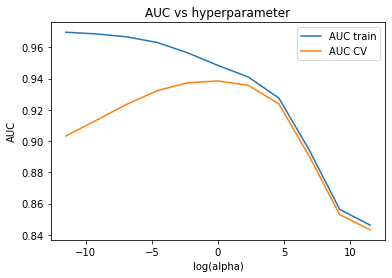

optimal alpha for which auc is maximum :  1


In [24]:
#Finding optimal_alpha by using simple for loop
from sklearn.naive_bayes import MultinomialNB
import math
auc_train=[]
auc_cv=[]
alpha_values=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in alpha_values:
    mnb_model=MultinomialNB(alpha=i)
    mnb_model.fit(X_train_bow,y_train)
    
    pred_train=mnb_model.predict_proba(X_train_bow)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_train))
    
    pred_cv=mnb_model.predict_proba(X_cv_bow)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_cv))
    auc_score_cv =roc_auc_score(y_cv,pred_cv)
    print(i,"-------->",auc_score_cv )

optimal_alpha=alpha_values[auc_cv.index(max(auc_cv))]
#Change the alpha_values in to log(alpha_values) for clear visualization
aplha_values=[math.log(x) for x in alpha_values]
#Graph between auc and hyperparamter
fig=plt.figure()
ax=plt.subplot(111)
ax.plot(aplha_values,auc_train,label="AUC train")
ax.plot(aplha_values,auc_cv,label="AUC CV")
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal alpha for which auc is maximum : ',optimal_alpha)

100%|██████████| 11/11 [00:03<00:00,  3.17it/s]


The optimal number of alpha is 1.


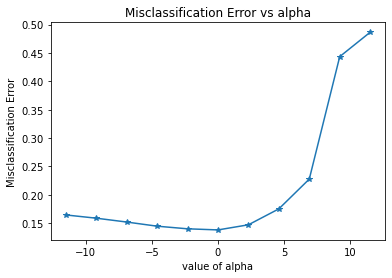

In [25]:
#Finding optimal_alpha by using 10-fold_cv
from sklearn.model_selection import cross_val_score
alpha_values=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
cv_scores=[]
#perfrom 10-fold cv
for i in tqdm(alpha_values):
    mnb_model=MultinomialNB(alpha=i)
    scores=cross_val_score(mnb_model,X_train_bow,y_train,cv=10)
    cv_scores.append(scores.mean())
#Changing to misclassification error
MSE=[1 - x for x in cv_scores]

#determing best alpha
optimal_alpha=alpha_values[MSE.index(min(MSE))]
aplha_values=[math.log(x) for x in alpha_values]
print('\nThe optimal number of alpha is %d.' % optimal_alpha)
#Plot the misclassfication error vs alpha
plt.plot(aplha_values,MSE,marker='*')
plt.title("Misclassification Error vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('Misclassification Error')
plt.show()


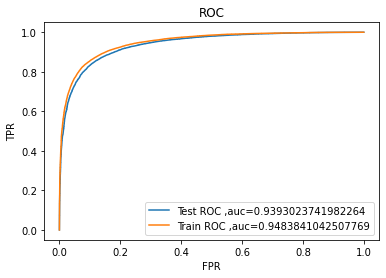

Auc on test data: 0.9393023741982264


In [26]:
mnb_optimal_model=MultinomialNB(alpha=optimal_alpha)
mnb_optimal_model.fit(X_train_bow,y_train)

y_test_pred=mnb_optimal_model.predict_proba(X_test_bow)[:,1]
fpr1,tpr1,threshold1=metrics.roc_curve(y_test,y_test_pred)

y_train_pred=mnb_optimal_model.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,threshold2=metrics.roc_curve(y_train,y_train_pred)

fig=plt.figure()
ax=plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,y_test_pred)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,y_train_pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()
print('Auc on test data:',roc_auc_score(y_test,y_test_pred))

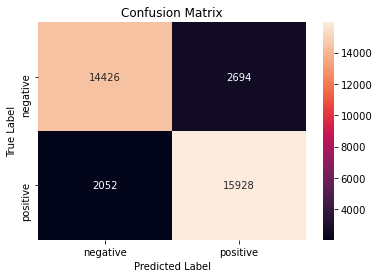

In [27]:
#Confusion_matrix
from sklearn.metrics import confusion_matrix
mnb_optimal_model=MultinomialNB(alpha=optimal_alpha)
mnb_optimal_model.fit(X_train_bow,y_train)
y_test_pred=mnb_optimal_model.predict(X_test_bow)

import seaborn as sns
conf_mat=confusion_matrix(y_test,y_test_pred)
class_label=['negative','positive']
df=pd.DataFrame(conf_mat,index=class_label,columns=class_label)
sns.heatmap(df,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [28]:
#Top feature
neg=mnb_optimal_model.feature_log_prob_[0,:].argsort()
pos=mnb_optimal_model.feature_log_prob_[1,:].argsort()
top_pos_words=np.take(count_vec.get_feature_names(),pos)
top_neg_words=np.take(count_vec.get_feature_names(),neg)
imp_df=pd.DataFrame(columns=['Pos_Words','Pos_Importance','Neg_Words','Neg_Importance'])
imp_df['Pos_Words']=top_pos_words[::-1]
imp_df['Pos_Importance']= np.take(mnb_optimal_model.feature_log_prob_[1,:],pos)[::-1]
imp_df['Neg_Words']=top_neg_words[::-1]
imp_df['Neg_Importance']= np.take(mnb_optimal_model.feature_log_prob_[0,:],neg)[::-1]
imp_df.head(10)

,Pos_Words,Pos_Importance,Neg_Words,Neg_Importance
0,not,-4.572226,not,-3.875052
1,tast,-4.604901,tast,-4.309288
2,like,-4.605385,like,-4.445808
3,love,-4.624737,product,-4.570257
4,great,-4.641812,one,-4.939143
5,good,-4.679311,flavor,-4.942347
6,flavor,-4.788338,would,-5.039732
7,product,-4.880561,tri,-5.077841
8,use,-4.917461,good,-5.175230
9,one,-4.981980,buy,-5.194552


In [29]:
model=MultinomialNB(alpha=1)
model.fit(X_train_bow,y_train)
features = model.feature_log_prob_ #log probability of features given a class
feature_names = count_vec.get_feature_names()
negative_features = np.argsort(features[0])[::-1] #Returns the indices that would sort an array
positive_features = np.argsort(features[1])[::-1]
print("Top 10 important features of positive class from BOW")
for i in list(positive_features[0:10]):
    print(feature_names[i])
print("Top 10 important features of negativeclass from BOW")
for i in list(negative_features[0:10]):
    print(feature_names[i])

Top 10 important features of positive class from BOW
not
tast
like
love
great
good
flavor
product
use
one
Top 10 important features of negativeclass from BOW
not
tast
like
product
one
flavor
would
tri
good
buy


# Applying Multinomial Naive Bayes on Tf-idf

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Conveting text into vectors using Tfidfvectorizer
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect.fit(X_train,y_train)
# we use the fited Countvectorizer to convert the text into vectors
X_train_tfidf=tf_idf_vect.transform(X_train)
X_cv_tfidf=tf_idf_vect.transform(X_cv)
X_test_tfidf=tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
#print("="*100)

After vectorizations
(57330, 887071) (57330,)
(24570, 887071) (24570,)
(35100, 887071) (35100,)


1e-05 --------> 0.8901857423752939
0.0001 --------> 0.9026757954130519
0.001 --------> 0.9189659302972578
0.01 --------> 0.9384987292916305
0.1 --------> 0.9544092478198729
1 --------> 0.9586524408324603
10 --------> 0.952290190575592
100 --------> 0.9388928651875632
1000 --------> 0.9238750199104995
10000 --------> 0.9179048237525088
100000 --------> 0.9170646993021504


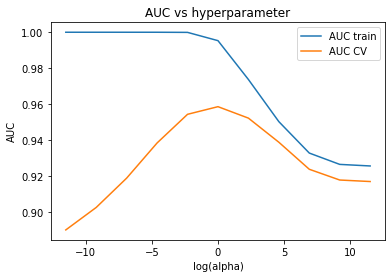

optimal alpha for which auc is maximum :  1


In [31]:
#Finding optimal_alpha by using simple for loop
from sklearn.naive_bayes import MultinomialNB
import math
auc_train=[]
auc_cv=[]
alpha_values=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
for i in alpha_values:
    mnb_model=MultinomialNB(alpha=i)
    mnb_model.fit(X_train_tfidf,y_train)
    
    pred_train=mnb_model.predict_proba(X_train_tfidf)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_train))
    
    pred_cv=mnb_model.predict_proba(X_cv_tfidf)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_cv))
    
    auc_score_cv =roc_auc_score(y_cv,pred_cv)
    print(i,"-------->",auc_score_cv )

optimal_alpha=alpha_values[auc_cv.index(max(auc_cv))]
#Change the alpha_values in to log(alpha_values) for clear visualization
alpha_values=[math.log(x) for x in alpha_values]
#Graph between auc and hyperparamter
fig=plt.figure()
ax=plt.subplot(111)
ax.plot(alpha_values,auc_train,label="AUC train")
ax.plot(alpha_values,auc_cv,label="AUC CV")
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal alpha for which auc is maximum : ',optimal_alpha)

100%|██████████| 11/11 [00:20<00:00,  1.85s/it]


The optimal number of alpha is 1.


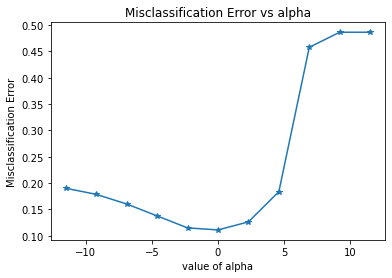

In [32]:
#Finding optimal_alpha by using 10-fold_cv
from sklearn.model_selection import cross_val_score
alpha_values=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
cv_scores=[]
#perfrom 10-fold cv
for i in tqdm(alpha_values):
    mnb_model=MultinomialNB(alpha=i)
    scores=cross_val_score(mnb_model,X_train_tfidf,y_train,cv=10)
    cv_scores.append(scores.mean())
#Changing to misclassification error
MSE=[1 - x for x in cv_scores]

#determing best alpha
optimal_alpha=alpha_values[MSE.index(min(MSE))]
aplha_values=[math.log(x) for x in alpha_values]
print('\nThe optimal number of alpha is %d.' % optimal_alpha)
#Plot the misclassfication error vs alpha
plt.plot(aplha_values,MSE,marker='*')
plt.title("Misclassification Error vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('Misclassification Error')
plt.show()

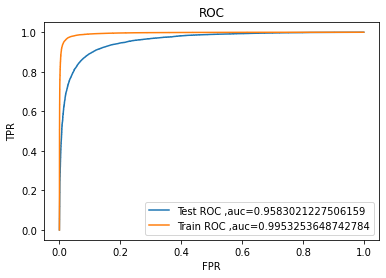

Auc on test data 0.9583021227506159


In [33]:
mnb_optimal_model=MultinomialNB(alpha=optimal_alpha)
mnb_optimal_model.fit(X_train_tfidf,y_train)

y_test_pred=mnb_optimal_model.predict_proba(X_test_tfidf)[:,1]
fpr1,tpr1,threshold1=metrics.roc_curve(y_test,y_test_pred)

y_train_pred=mnb_optimal_model.predict_proba(X_train_tfidf)[:,1]
fpr2,tpr2,threshold2=metrics.roc_curve(y_train,y_train_pred)

fig=plt.figure()
ax=plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,y_test_pred)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,y_train_pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()
print("Auc on test data",roc_auc_score(y_test,y_test_pred))

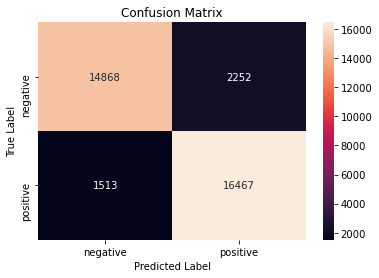

In [34]:
#Confusion_matrix
from sklearn.metrics import confusion_matrix
mnb_optimal_model=MultinomialNB(alpha=optimal_alpha)
mnb_optimal_model.fit(X_train_tfidf,y_train)
y_test_pred=mnb_optimal_model.predict(X_test_tfidf)

import seaborn as sns
conf_mat=confusion_matrix(y_test,y_test_pred)
class_label=['negative','positive']
df=pd.DataFrame(conf_mat,index=class_label,columns=class_label)
sns.heatmap(df,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [35]:
#Top feature
neg=mnb_optimal_model.feature_log_prob_[0,:].argsort()
pos=mnb_optimal_model.feature_log_prob_[1,:].argsort()
top_pos_words=np.take(tf_idf_vect.get_feature_names(),pos)
top_neg_words=np.take(tf_idf_vect.get_feature_names(),neg)
imp_df=pd.DataFrame(columns=['Pos_Words','Pos_Importance','Neg_Words','Neg_Importance'])
imp_df['Pos_Words']=top_pos_words[::-1]
imp_df['Pos_Importance']= np.take(mnb_optimal_model.feature_log_prob_[1,:],pos)[::-1]
imp_df['Neg_Words']=top_neg_words[::-1]
imp_df['Neg_Importance']= np.take(mnb_optimal_model.feature_log_prob_[0,:],neg)[::-1]
imp_df.head(10)

,Pos_Words,Pos_Importance,Neg_Words,Neg_Importance
0,great,-7.746975,not,-7.361351
1,love,-7.773131,tast,-7.649672
2,good,-7.889007,like,-7.787164
3,tea,-7.931947,product,-7.819529
4,like,-7.939492,flavor,-8.112524
5,tast,-7.940037,coffe,-8.121663
6,flavor,-7.956654,one,-8.155140
7,coffe,-7.980030,would,-8.157807
8,not,-8.052472,tri,-8.249377
9,use,-8.067855,order,-8.283515


# Applying Bernoulli  Naive Bayes on Bow

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
# Converting "CleanrText" into vectors Using BOW
count_vec=CountVectorizer()
count_vec.fit(X_train) #fit ha to happen only on train data
# Using the fiited CountVectorizer to convert text to vectors
X_train_bow=count_vec.transform(X_train)
X_test_bow=count_vec.transform(X_test)
X_cv_bow=count_vec.transform(X_cv)
X_tr_bow=count_vec.transform(X_tr)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print(X_tr_bow.shape, y_tr.shape)
#print("="*100)

After vectorizations
(57330, 29315) (57330,)
(24570, 29315) (24570,)
(35100, 29315) (35100,)
(81900, 29315) (81900,)


1e-05 --------> 0.8746291160865398
0.0001 --------> 0.8849012497246509
0.001 --------> 0.8963801295123075
0.01 --------> 0.9079278511462067
0.1 --------> 0.9173787788304444
0.5 --------> 0.9211154255360586
1 --------> 0.9218540458051707
10 --------> 0.9211190918856491
100 --------> 0.9131775068458139
1000 --------> 0.5001748079683104
10000 --------> 0.5
100000 --------> 0.5


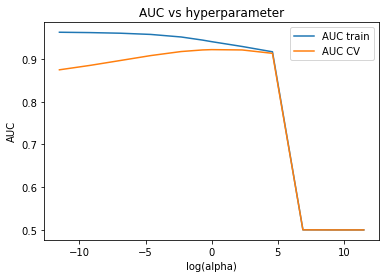

optimal alpha for which auc is maximum :  1


In [37]:
#Finding optimal_alpha by using simple for loop
from sklearn.naive_bayes import BernoulliNB
import math
auc_train=[]
auc_cv=[]
alpha_values=[0.00001,0.0001,0.001,0.01,0.1,0.5,1,10,100,1000,10000,100000]
for i in alpha_values:
    b_nb_model=BernoulliNB(alpha=i)
    b_nb_model.fit(X_train_bow,y_train)
    
    pred_train=b_nb_model.predict_proba(X_train_bow)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_train))
    
    pred_cv=b_nb_model.predict_proba(X_cv_bow)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_cv))
    auc_score_cv =roc_auc_score(y_cv,pred_cv)
    print(i,"-------->",auc_score_cv )

optimal_alpha=alpha_values[auc_cv.index(max(auc_cv))]
#Change the alpha_values in to log(alpha_values) for clear visualization
aplha_values=[math.log(x) for x in alpha_values]
#Graph between auc and hyperparamter
fig=plt.figure()
ax=plt.subplot(111)
ax.plot(aplha_values,auc_train,label="AUC train")
ax.plot(aplha_values,auc_cv,label="AUC CV")
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal alpha for which auc is maximum : ',optimal_alpha)

# Or (finding hyperparameter )

100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


The optimal number of alpha is 1.


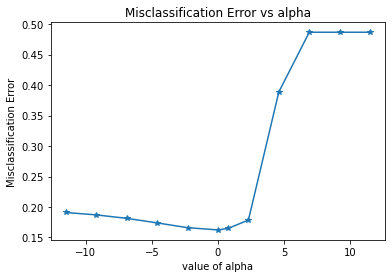

In [38]:
#Finding optimal_alpha by using 10-fold_cv
from sklearn.model_selection import cross_val_score
alpha_values=[0.00001,0.0001,0.001,0.01,0.1,1,2.1,10,100,1000,10000,100000]
cv_scores=[]
#perfrom 10-fold cv
for i in tqdm(alpha_values):
    b_nb_model=BernoulliNB(alpha=i)
    scores=cross_val_score(b_nb_model,X_train_bow,y_train,cv=10)
    cv_scores.append(scores.mean())
#Changing to misclassification error
MSE=[1 - x for x in cv_scores]

#determing best alpha
optimal_alpha=alpha_values[MSE.index(min(MSE))]
aplha_values=[math.log(x) for x in alpha_values]
print('\nThe optimal number of alpha is %d.' % optimal_alpha)
#Plot the misclassfication error vs alpha
plt.plot(aplha_values,MSE,marker='*')
plt.title("Misclassification Error vs alpha")
plt.xlabel('value of alpha')
plt.ylabel('Misclassification Error')
plt.show()


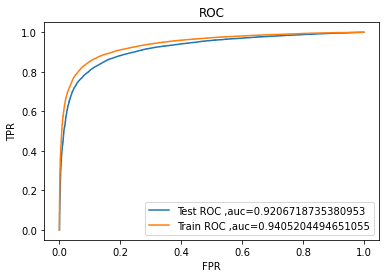

Auc on test data: 0.9206718735380953


In [39]:
b_nb_optimal_model=BernoulliNB(alpha=optimal_alpha)
b_nb_optimal_model.fit(X_train_bow,y_train)

y_test_pred=b_nb_optimal_model.predict_proba(X_test_bow)[:,1]
fpr1,tpr1,threshold1=metrics.roc_curve(y_test,y_test_pred)

y_train_pred=b_nb_optimal_model.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,threshold2=metrics.roc_curve(y_train,y_train_pred)

fig=plt.figure()
ax=plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,y_test_pred)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,y_train_pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()
print('Auc on test data:',roc_auc_score(y_test,y_test_pred))

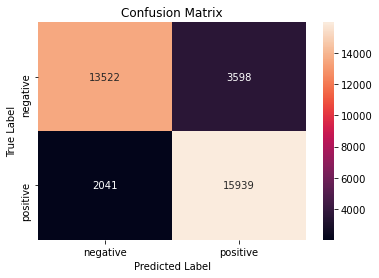

In [40]:
#Confusion_matrix
from sklearn.metrics import confusion_matrix
b_nb_optimal_model=BernoulliNB(alpha=optimal_alpha)
b_nb_optimal_model.fit(X_train_bow,y_train)
y_test_pred=b_nb_optimal_model.predict(X_test_bow)

import seaborn as sns
conf_mat=confusion_matrix(y_test,y_test_pred)
class_label=['negative','positive']
df=pd.DataFrame(conf_mat,index=class_label,columns=class_label)
sns.heatmap(df,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [41]:
#Top feature
neg=b_nb_optimal_model.feature_log_prob_[0,:].argsort()
pos=b_nb_optimal_model.feature_log_prob_[1,:].argsort()
top_pos_words=np.take(count_vec.get_feature_names(),pos)
top_neg_words=np.take(count_vec.get_feature_names(),neg)
imp_df=pd.DataFrame(columns=['Pos_Words','Pos_Importance','Neg_Words','Neg_Importance'])
imp_df['Pos_Words']=top_pos_words[::-1]
imp_df['Pos_Importance']= np.take(b_nb_optimal_model.feature_log_prob_[1,:],pos)[::-1]
imp_df['Neg_Words']=top_neg_words[::-1]
imp_df['Neg_Importance']= np.take(b_nb_optimal_model.feature_log_prob_[0,:],neg)[::-1]
imp_df.head(10)

,Pos_Words,Pos_Importance,Neg_Words,Neg_Importance
0,not,-1.119969,not,-0.578240
1,like,-1.177280,tast,-0.988831
2,tast,-1.203192,like,-1.006720
3,love,-1.271797,product,-1.184695
4,good,-1.276169,one,-1.363367
5,great,-1.297450,would,-1.420311
6,flavor,-1.416820,tri,-1.477705
7,one,-1.463273,flavor,-1.551704
8,use,-1.483584,good,-1.557643
9,product,-1.527362,buy,-1.597572


# Applying Bernoulli Naive Bayes on tfidf

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Conveting text into vectors using Tfidfvectorizer
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect.fit(X_train,y_train)
# we use the fited Countvectorizer to convert the text into vectors
X_train_tfidf=tf_idf_vect.transform(X_train)
X_cv_tfidf=tf_idf_vect.transform(X_cv)
X_test_tfidf=tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_cv.shape)
print(X_test_tfidf.shape, y_test.shape)
#print("="*100)

After vectorizations
(57330, 887071) (57330,)
(24570, 887071) (24570,)
(35100, 887071) (35100,)


1e-05 --------> 0.8877942017642566
0.0001 --------> 0.8984522932834365
0.001 --------> 0.9109899193618562
0.01 --------> 0.9257947185670606
0.1 --------> 0.9406612854864767
0.5 --------> 0.947450194745816
1 --------> 0.9485720877755915
10 --------> 0.9432683119824824
100 --------> 0.5
1000 --------> 0.5
10000 --------> 0.5
100000 --------> 0.5


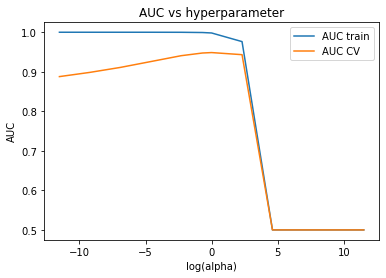

optimal alpha for which auc is maximum :  1


In [43]:
#Finding optimal_alpha by using simple for loop
from sklearn.naive_bayes import BernoulliNB
import math
auc_train=[]
auc_cv=[]
alpha_values=[0.00001,0.0001,0.001,0.01,0.1,0.5,1,10,100,1000,10000,100000]
for i in alpha_values:
    b_nb_model=BernoulliNB(alpha=i)
    b_nb_model.fit(X_train_tfidf,y_train)
    
    pred_train=b_nb_model.predict_proba(X_train_tfidf)[:,1]
    auc_train.append(roc_auc_score(y_train,pred_train))
    
    pred_cv=b_nb_model.predict_proba(X_cv_tfidf)[:,1]
    auc_cv.append(roc_auc_score(y_cv,pred_cv))
    auc_score_cv =roc_auc_score(y_cv,pred_cv)
    print(i,"-------->",auc_score_cv )

optimal_alpha=alpha_values[auc_cv.index(max(auc_cv))]
#Change the alpha_values in to log(alpha_values) for clear visualization
aplha_values=[math.log(x) for x in alpha_values]
#Graph between auc and hyperparamter
fig=plt.figure()
ax=plt.subplot(111)
ax.plot(aplha_values,auc_train,label="AUC train")
ax.plot(aplha_values,auc_cv,label="AUC CV")
plt.title('AUC vs hyperparameter')
plt.xlabel('log(alpha)')
plt.ylabel('AUC')
ax.legend()
plt.show()
print('optimal alpha for which auc is maximum : ',optimal_alpha)

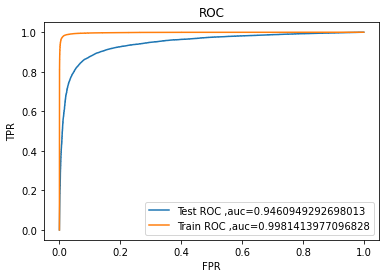

Auc on test data: 0.9460949292698013


In [44]:
b_nb_optimal_model=BernoulliNB(alpha=optimal_alpha)
b_nb_optimal_model.fit(X_train_tfidf,y_train)

y_test_pred=b_nb_optimal_model.predict_proba(X_test_tfidf)[:,1]
fpr1,tpr1,threshold1=metrics.roc_curve(y_test,y_test_pred)

y_train_pred=b_nb_optimal_model.predict_proba(X_train_tfidf)[:,1]
fpr2,tpr2,threshold2=metrics.roc_curve(y_train,y_train_pred)

fig=plt.figure()
ax=plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test,y_test_pred)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_train,y_train_pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()
print('Auc on test data:',roc_auc_score(y_test,y_test_pred))



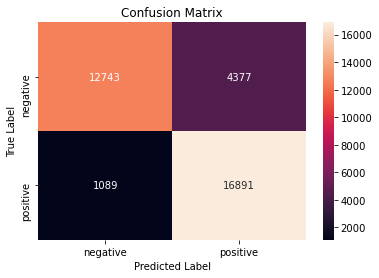

In [45]:
#Confusion_matrix
from sklearn.metrics import confusion_matrix
b_nb_optimal_model=BernoulliNB(alpha=optimal_alpha)
b_nb_optimal_model.fit(X_train_tfidf,y_train)
y_test_pred=b_nb_optimal_model.predict(X_test_tfidf)

import seaborn as sns
conf_mat=confusion_matrix(y_test,y_test_pred)
class_label=['negative','positive']
df=pd.DataFrame(conf_mat,index=class_label,columns=class_label)
sns.heatmap(df,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [46]:
#Top feature
neg=b_nb_optimal_model.feature_log_prob_[0,:].argsort()
pos=b_nb_optimal_model.feature_log_prob_[1,:].argsort()
top_pos_words=np.take(tf_idf_vect.get_feature_names(),pos)
top_neg_words=np.take(tf_idf_vect.get_feature_names(),neg)
imp_df=pd.DataFrame(columns=['Pos_Words','Pos_Importance','Neg_Words','Neg_Importance'])
imp_df['Pos_Words']=top_pos_words[::-1]
imp_df['Pos_Importance']= np.take(b_nb_optimal_model.feature_log_prob_[1,:],pos)[::-1]
imp_df['Neg_Words']=top_neg_words[::-1]
imp_df['Neg_Importance']= np.take(b_nb_optimal_model.feature_log_prob_[0,:],neg)[::-1]
imp_df.head(10)

,Pos_Words,Pos_Importance,Neg_Words,Neg_Importance
0,not,-1.119969,not,-0.578240
1,like,-1.177280,tast,-0.988831
2,tast,-1.203192,like,-1.006720
3,love,-1.271797,product,-1.184695
4,good,-1.276169,one,-1.363367
5,great,-1.297450,would,-1.420311
6,flavor,-1.416820,tri,-1.477705
7,one,-1.463273,flavor,-1.551704
8,use,-1.483584,good,-1.557643
9,product,-1.527362,buy,-1.597572


In [47]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best hyper parameter(alpha)","Test Auc Score"]
x.add_row(["BoW","MultinomialNB",1 , 0.9391294487384737])
x.add_row(["Tf-Idf","MultinomialNB",1,0.9583785040231618])
x.add_row(["BoW","BernoulliNB",1 , 0.9238908301539613])
x.add_row(["Tf-Idf","BernoulliNB",1,0.9487151449429793])
print('****Final Conclusion:****')
print(x)

****Final Conclusion:****
+------------+---------------+-----------------------------+--------------------+
| Vectorizer |     Model     | Best hyper parameter(alpha) |   Test Auc Score   |
+------------+---------------+-----------------------------+--------------------+
|    BoW     | MultinomialNB |              1              | 0.9391294487384737 |
|   Tf-Idf   | MultinomialNB |              1              | 0.9583785040231618 |
|    BoW     |  BernoulliNB  |              1              | 0.9238908301539613 |
|   Tf-Idf   |  BernoulliNB  |              1              | 0.9487151449429793 |
+------------+---------------+-----------------------------+--------------------+


1. **Naive bayes is much better model than Knn model for Text classification for Amazon fine food data**

1. **When we are train Model with review and summary data as training data, then we are getting slightly higher accuracy than Only Review data as training data.So Feature engineering for Concatenating Summary data into review data work here**

1. **Naive Bayes with Bow model has more accuracy than TfIdf model here.**

1. **Naive Bayes with Bow model has optimal value of alpha 1.0 where as Naive Bayes with TfIdf model has optimal value of alpha is 0.1.So for diiferent vectorization of text optimal value may differ.**